<h1><center>EE69210: Machine Learning for Signal Processing Laboratory</center></h1>
<h2><center>Experiment-5: Regression and Classification</center></h2>
<h3><center>Anirvan Krishna | 21EE38002</center></h3>

In [189]:
from scipy import io
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

## Linear Classification with Support Vector Machines (SVMs)

In [190]:
data = io.loadmat('data\Classification_Points_Data1.mat')
data

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Wed Feb  8 15:00:57 2023',
 '__version__': '1.0',
 '__globals__': [],
 'A': array([[0.4952, 6.8088],
        [2.6505, 8.959 ],
        [3.4403, 5.3366],
        [3.401 , 6.1624],
        [5.2153, 8.2529],
        [7.6393, 9.4764],
        [1.5041, 3.337 ],
        [3.9855, 8.3138],
        [1.85  , 5.0079],
        [1.2631, 8.6463],
        [3.8957, 4.9014],
        [1.9751, 8.6199],
        [1.2565, 6.4558],
        [4.3732, 6.1261],
        [0.4297, 8.3551],
        [3.6931, 6.6134],
        [7.8164, 9.8767],
        [4.8561, 8.7376],
        [6.775 , 7.9386],
        [2.3734, 4.774 ],
        [0.8746, 3.0892],
        [2.3088, 9.0919],
        [2.552 , 9.0469],
        [3.3773, 6.1886],
        [0.869 , 3.755 ],
        [1.8738, 8.1053],
        [0.9469, 5.1476],
        [0.9718, 5.5951],
        [0.4309, 7.5763],
        [2.2699, 7.1371]]),
 'B': array([[7.245 , 3.4422],
        [7.703 , 5.0965],
        [5.767 , 

In [191]:
A = data['A']
B = data['B']

In [192]:
X = np.concatenate((A, B), axis=0)
y = -1*np.ones(B.shape[0])
y = np.concatenate((np.ones(A.shape[0]), y))

print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")

Shape of X: (60, 2)
Shape of y: (60,)


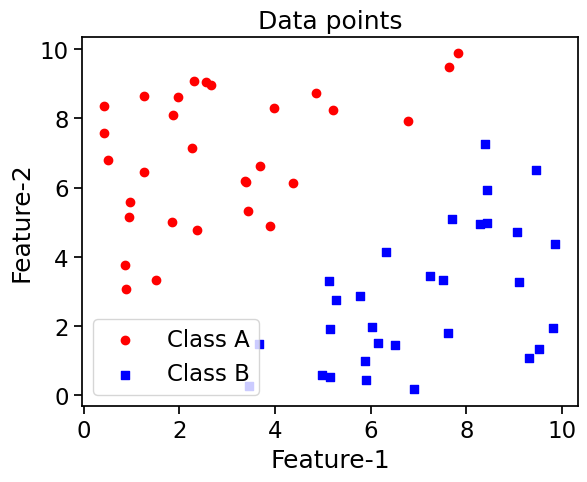

In [193]:
plt.figure()
plt.scatter(X[y==1, 0], X[y==1, 1], c='red', marker='o', label='Class A')
plt.scatter(X[y==-1, 0], X[y==-1, 1], c='blue', marker='s', label='Class B')
plt.ylabel('Feature-2')
plt.xlabel('Feature-1')
plt.title('Data points')
plt.legend()
plt.show()

### Primal SVM Formulation

In this section, we will implement the Primal SVM formulation using convex optimization techniques. The primal SVM aims to find the optimal hyperplane that separates the data points of two classes with the maximum margin.

#### Objective Function

Given a dataset $(\mathbf{X}, \mathbf{y})$ where $\mathbf{X} \in \mathbb{R}^{n \times d}$ and $\mathbf{y} \in \{-1, 1\}^n$, the primal SVM optimization problem can be formulated as:

$$
\min_{\mathbf{w}, b, \boldsymbol{\xi}} \quad \frac{1}{2} \|\mathbf{w}\|^2 + C \sum_{i=1}^{n} \xi_i
$$

subject to:

$$
y_i (\mathbf{w}^\top \mathbf{x}_i + b) \geq 1 - \xi_i, \quad \xi_i \geq 0, \quad i = 1, \ldots, n
$$

where:
- $\mathbf{w}$ is the weight vector.
- $b$ is the bias term.
- $\xi_i$ are the slack variables that allow for some misclassification in the case of non-linearly separable data.
- $C$ is the regularization parameter that controls the trade-off between maximizing the margin and minimizing the classification error.


In [194]:
class PrimalSVM:
    def __init__(self, C=1.0):
        self.C = C
        self.w = None
        self.b = None
        self.support_vectors = None
        self.support_vector_labels = None
        
    def fit(self, X, y):
        n_samples, n_features = X.shape
        
        # Initialize the weights and bias
        w = cp.Variable(n_features)
        b = cp.Variable()
        
        # For soft margin (C parameter)
        slack = cp.Variable(n_samples)
        
        # Define the objective function with regularization
        obj = cp.Minimize(0.5 * cp.sum_squares(w) + self.C * cp.sum(slack))
        
        # Define the constraints with slack variables
        constraints = [
            cp.multiply(y, (X @ w + b)) >= 1 - slack,
            slack >= 0
        ]

        # Solve the optimization problem
        prob = cp.Problem(obj, constraints)
        prob.solve(solver=cp.SCS)

        self.w = w.value
        self.b = b.value
        
        # Find support vectors (points near the margin)
        margins = y * (X @ self.w + self.b)

        # Consider points with margin close to 1 as support vectors
        sv_threshold = 1e-3
        sv_indices = np.where(np.abs(margins - 1) < sv_threshold)[0]
        
        self.support_vectors = X[sv_indices]
        self.support_vector_labels = y[sv_indices]
        
        return self

    def predict(self, X):
        return np.sign(X @ self.w + self.b)
    
    def decision_function(self, X):  
        if self.w is None:
            raise ValueError("Model not fitted. Call fit first.")
            
        return X @ self.w + self.b

def plot_svm_decision_boundary(model, X, y, title='SVM Decision Boundary'):

    # Create a mesh grid
    h = 0.02  # Step size
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    
    # Compute the decision function
    mesh_points = np.c_[xx.ravel(), yy.ravel()]
    Z = model.decision_function(mesh_points)
    Z = Z.reshape(xx.shape)
    
    # Plot the decision boundary and margins
    plt.contourf(xx, yy, Z, cmap=plt.cm.RdBu, alpha=0.8)
    plt.contour(xx, yy, Z, colors=['k'], linestyles=['-'], levels=[0])
    
    # Plot the data points
    plt.scatter(X[y == 1, 0], X[y == 1, 1], c='b', marker='o', label='Class 1', edgecolors='k')
    plt.scatter(X[y == -1, 0], X[y == -1, 1], c='r', marker='x', label='Class -1', edgecolors='k')
    
    # Highlight support vectors
    if hasattr(model, 'support_vectors') and model.support_vectors is not None:
        plt.scatter(model.support_vectors[:, 0], model.support_vectors[:, 1], 
                    s=100, facecolors='none', edgecolors='g', linewidth=2,
                    label='Support Vectors')
    
    plt.title(title)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend()
    plt.tight_layout()
    plt.show()

Accuracy: 1.0
              precision    recall  f1-score   support

        -1.0       1.00      1.00      1.00        30
         1.0       1.00      1.00      1.00        30

    accuracy                           1.00        60
   macro avg       1.00      1.00      1.00        60
weighted avg       1.00      1.00      1.00        60



C:\Users\Anirvan Krishna\AppData\Local\Temp\ipykernel_18052\4138269871.py:75: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(X[y == -1, 0], X[y == -1, 1], c='r', marker='x', label='Class -1', edgecolors='k')


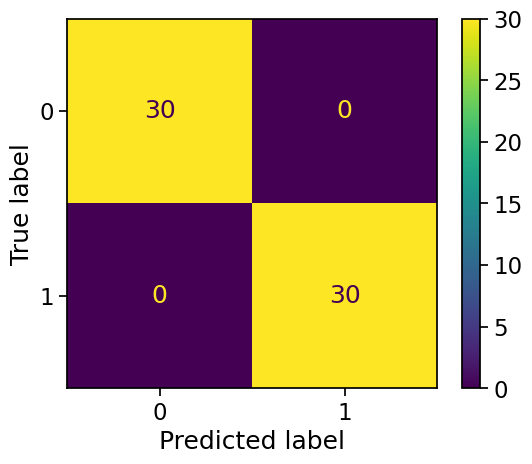

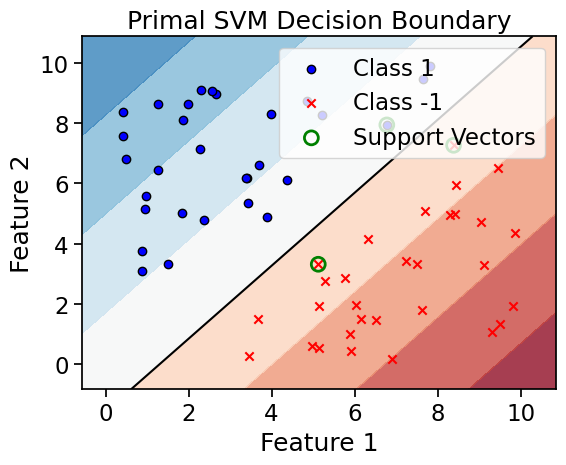

In [195]:
psvm = PrimalSVM()
psvm.fit(X, y)

y_pred = psvm.predict(X)
accuracy = accuracy_score(y, y_pred)

print(f"Accuracy: {accuracy}")
print(classification_report(y, y_pred))

cm = confusion_matrix(y, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

fig = plt.figure(figsize=(6, 5))
plot_svm_decision_boundary(psvm, X, y, title='Primal SVM Decision Boundary')

In [196]:
print(f"Weights: {psvm.w}")
print(f"Bias: {psvm.b}")
print(f"Support vectors:\n {psvm.support_vectors}")

Weights: [-0.92288282  0.76271838]
Bias: 1.1976144708333099
Support vectors:
 [[6.775  7.9386]
 [5.1235 3.3181]
 [8.3827 7.2617]]


### Dual SVM Formulation

In this section, we will implement the Dual SVM formulation using convex optimization techniques. The dual SVM aims to find the optimal hyperplane that separates the data points of two classes with the maximum margin by solving the dual optimization problem.

#### Objective Function

Given a dataset $(\mathbf{X}, \mathbf{y})$ where $\mathbf{X} \in \mathbb{R}^{n \times d}$ and $\mathbf{y} \in \{-1, 1\}^n$, the dual SVM optimization problem can be formulated as:

$$
\max_{\boldsymbol{\alpha}} \quad \sum_{i=1}^{n} \alpha_i - \frac{1}{2} \sum_{i=1}^{n} \sum_{j=1}^{n} \alpha_i \alpha_j y_i y_j \mathbf{x}_i^\top \mathbf{x}_j
$$

subject to:

$$
\sum_{i=1}^{n} \alpha_i y_i = 0, \quad 0 \leq \alpha_i \leq C, \quad i = 1, \ldots, n
$$

where:
- $\boldsymbol{\alpha}$ are the Lagrange multipliers.
- $C$ is the regularization parameter that controls the trade-off between maximizing the margin and minimizing the classification error.

#### Decision Function

The decision function for a new data point $\mathbf{x}$ is given by:

$$
f(\mathbf{x}) = \sum_{i=1}^{n} \alpha_i y_i \mathbf{x}_i^\top \mathbf{x} + b
$$

where $b$ is the bias term, which can be computed using the support vectors.

#### Computing Primal Weight and Bias

Once we have the optimal Lagrange multipliers $\boldsymbol{\alpha}$ from the dual problem, we can compute the primal weight vector $\mathbf{w}$ and the bias term $b$ as follows:

1. **Primal Weight Vector $\mathbf{w}$**:
    The primal weight vector $\mathbf{w}$ can be computed using the support vectors and their corresponding Lagrange multipliers:
    $$
    \mathbf{w} = \sum_{i=1}^{n} \alpha_i y_i \mathbf{x}_i
    $$

2. **Bias Term $b$**:
    The bias term $b$ can be computed using the support vectors. For any support vector $\mathbf{x}_i$ with $0 < \alpha_i < C$, the bias term $b$ is given by:
    $$
    b = y_i - \sum_{j=1}^{n} \alpha_j y_j \mathbf{x}_j^\top \mathbf{x}_i
    $$
    For numerical stability, it is common to average the bias term over all support vectors:
    $$
    b = \frac{1}{|\mathcal{S}|} \sum_{i \in \mathcal{S}} \left( y_i - \sum_{j=1}^{n} \alpha_j y_j \mathbf{x}_j^\top \mathbf{x}_i \right)
    $$
    where $\mathcal{S}$ is the set of support vectors.

In [197]:
class DualSVM:
    def __init__(self, C=1.0):
        self.C = C
        self.alphas = None
        self.support_vectors = None
        self.support_vector_labels = None
        self.b = 0
        self.w = None
        
    def fit(self, X, y):
        n_samples, n_features = X.shape
        
        # Compute the kernel matrix
        K = X @ X.T
        
        # Create the optimization variables
        alphas = cp.Variable(n_samples)
        
        # Create the objective function
        y_matrix = np.outer(y, y)
        P = cp.Parameter((n_samples, n_samples), PSD=True)
        P.value = y_matrix * K
        objective = cp.Minimize(0.5 * cp.quad_form(alphas, P) - cp.sum(alphas))
        
        # Create the constraints
        box_constraints = [0 <= alphas, alphas <= self.C]
        equality_constraint = [cp.sum(cp.multiply(y, alphas)) == 0]
        
        # Formulate and solve the problem
        problem = cp.Problem(objective, box_constraints + equality_constraint)
        problem.solve(solver=cp.OSQP)
        
        # Extract the optimal alphas
        self.alphas = alphas.value
        
        # Get support vectors (points with non-zero alphas)
        sv_threshold = 1e-5
        sv_indices = np.where(self.alphas > sv_threshold)[0]
        
        self.support_vectors = X[sv_indices]
        self.support_vector_labels = y[sv_indices]
        self.support_alphas = self.alphas[sv_indices]
        
        # Calculate primal weight vector w from dual solution
        self.w = np.zeros(n_features)
        for i in range(len(sv_indices)):
            self.w += self.support_alphas[i] * self.support_vector_labels[i] * self.support_vectors[i]
        
        # Compute the bias term b
        margins = np.zeros(len(sv_indices))
        for i in range(len(sv_indices)):
            margins[i] = self.support_vector_labels[i] - np.dot(self.w, self.support_vectors[i])
        
        self.b = np.mean(margins)
        
        return self
    
    def predict(self, X):
        return np.sign(X @ self.w + self.b)
    
    def decision_function(self, X):
        return X @ self.w + self.b

Dual SVM Accuracy: 1.0
              precision    recall  f1-score   support

        -1.0       1.00      1.00      1.00        30
         1.0       1.00      1.00      1.00        30

    accuracy                           1.00        60
   macro avg       1.00      1.00      1.00        60
weighted avg       1.00      1.00      1.00        60



C:\Users\Anirvan Krishna\AppData\Roaming\Python\Python310\site-packages\cvxpy\reductions\solvers\solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
C:\Users\Anirvan Krishna\AppData\Local\Temp\ipykernel_18052\4138269871.py:75: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(X[y == -1, 0], X[y == -1, 1], c='r', marker='x', label='Class -1', edgecolors='k')


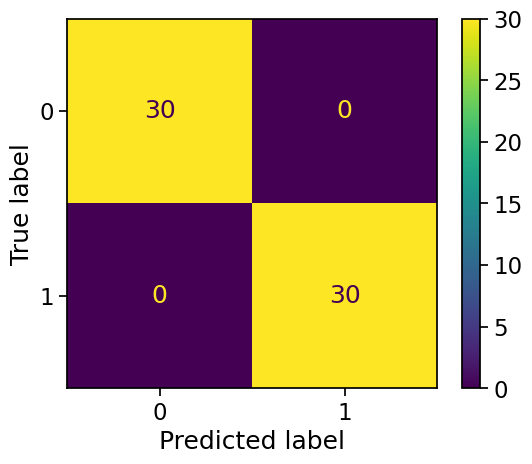

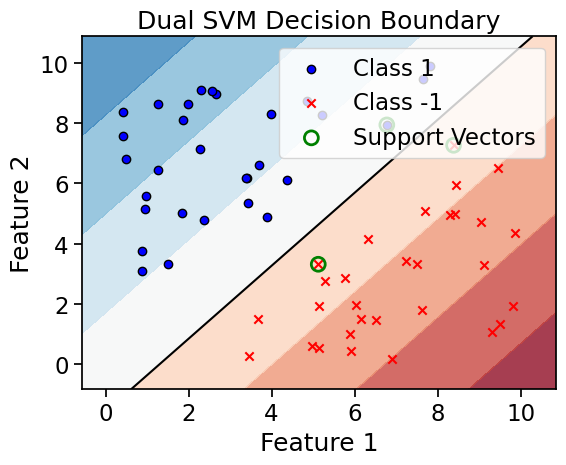

In [198]:
# Run the dual SVM model
dsvm = DualSVM(C=1.0)
dsvm.fit(X, y)

# Make predictions
y_pred_dual = dsvm.predict(X)
accuracy_dual = accuracy_score(y, y_pred_dual)

print(f"Dual SVM Accuracy: {accuracy_dual}")
print(classification_report(y, y_pred_dual))

cm = confusion_matrix(y, y_pred_dual)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

# Plot decision boundary
plt.figure(figsize=(6, 5))
plot_svm_decision_boundary(dsvm, X, y, title='Dual SVM Decision Boundary')

In [199]:
# Compare with primal SVM weights
print(f"\nPrimal weights: {psvm.w}")
print(f"Dual weights: {dsvm.w}")
print(f"Primal bias: {psvm.b}")
print(f"Dual bias: {dsvm.b}\n")

# Calculate weight difference
weight_diff = np.linalg.norm(psvm.w - dsvm.w)
print(f"Weight difference norm: {weight_diff}")

# Calculate bias difference
bias_diff = np.linalg.norm(psvm.b - dsvm.b)
print(f"Bias difference norm: {bias_diff}")


Primal weights: [-0.92288282  0.76271838]
Dual weights: [-0.92288126  0.76271797]
Primal bias: 1.1976144708333099
Dual bias: 1.1976076276102534

Weight difference norm: 1.6117904736246743e-06
Bias difference norm: 6.843223056440806e-06


## Non-Linear Classification with Kernelized SVMs
Kernelized Support Vector Machines (SVMs) extend the concept of SVMs to non-linear classification problems by using kernel functions. These functions implicitly map the input features into a higher-dimensional space where a linear separation is possible.

### Objective Function

Given a dataset $(\mathbf{X}, \mathbf{y})$ where $\mathbf{X} \in \mathbb{R}^{n \times d}$ and $\mathbf{y} \in \{-1, 1\}^n$, the dual SVM optimization problem with a kernel function $K(\mathbf{x}_i, \mathbf{x}_j)$ can be formulated as:

$$
\max_{\boldsymbol{\alpha}} \quad \sum_{i=1}^{n} \alpha_i - \frac{1}{2} \sum_{i=1}^{n} \sum_{j=1}^{n} \alpha_i \alpha_j y_i y_j K(\mathbf{x}_i, \mathbf{x}_j)
$$

subject to:

$$
\sum_{i=1}^{n} \alpha_i y_i = 0, \quad 0 \leq \alpha_i \leq C, \quad i = 1, \ldots, n
$$

where:
- $\boldsymbol{\alpha}$ are the Lagrange multipliers.
- $C$ is the regularization parameter that controls the trade-off between maximizing the margin and minimizing the classification error.
- $K(\mathbf{x}_i, \mathbf{x}_j)$ is the kernel function.

### Kernel Functions

Commonly used kernel functions include:

1. **Linear Kernel**:
    $$
    K(\mathbf{x}_i, \mathbf{x}_j) = \mathbf{x}_i^\top \mathbf{x}_j
    $$

2. **Gaussian (RBF) Kernel**:
    $$
    K(\mathbf{x}_i, \mathbf{x}_j) = \exp\left(-\frac{\|\mathbf{x}_i - \mathbf{x}_j\|^2}{2\sigma^2}\right)
    $$

### Decision Function

The decision function for a new data point $\mathbf{x}$ is given by:

$$
f(\mathbf{x}) = \sum_{i=1}^{n} \alpha_i y_i K(\mathbf{x}_i, \mathbf{x}) + b
$$

where $b$ is the bias term, which can be computed using the support vectors.

### Computing Primal Weight and Bias

Once we have the optimal Lagrange multipliers $\boldsymbol{\alpha}$ from the dual problem, we can compute the bias term $b$ as follows:

1. **Bias Term $b$**:
    The bias term $b$ can be computed using the support vectors. For any support vector $\mathbf{x}_i$ with $0 < \alpha_i < C$, the bias term $b$ is given by:
    $$
    b = y_i - \sum_{j=1}^{n} \alpha_j y_j K(\mathbf{x}_j, \mathbf{x}_i)
    $$
    For numerical stability, it is common to average the bias term over all support vectors:
    $$
    b = \frac{1}{|\mathcal{S}|} \sum_{i \in \mathcal{S}} \left( y_i - \sum_{j=1}^{n} \alpha_j y_j K(\mathbf{x}_j, \mathbf{x}_i) \right)
    $$
    where $\mathcal{S}$ is the set of support vectors.

In [200]:
def linear_kernel(X1, X2=None):
    if X2 is None:
        X2 = X1
    return np.dot(X1, X2.T)


def gaussian_kernel(X1, X2=None, sigma=1.0):

    if X2 is None:
        X2 = X1

    n1 = X1.shape[0]
    n2 = X2.shape[0]
    K = np.zeros((n1, n2))

    for i in range(n1):
        for j in range(n2):
            K[i, j] = np.exp(-np.linalg.norm(X1[i] - X2[j])
                             ** 2 / (2 * sigma**2))
    return K

class KernelSVM:
    def __init__(self, C=1.0, kernel='linear', sigma=1.0):
        self.C = C
        self.kernel_type = kernel
        self.sigma = sigma
        self.kernel_func = linear_kernel if kernel == 'linear' else lambda X1, X2=None: gaussian_kernel(
            X1, X2, sigma)
        self.alphas = None
        self.support_vectors = None
        self.support_vector_labels = None
        self.b = 0

    def fit(self, X, y):
        n_samples = X.shape[0]

        # Compute the kernel matrix
        K = self.kernel_func(X)

        # Create the optimization variables
        alphas = cp.Variable(n_samples)

        # Create the objective function
        y_matrix = np.outer(y, y)
        P = cp.Parameter((n_samples, n_samples), PSD=True)
        P.value = y_matrix * K
        objective = cp.Minimize(0.5 * cp.quad_form(alphas, P) - cp.sum(alphas))

        # Create the constraints
        box_constraints = [0 <= alphas, alphas <= self.C]
        equality_constraint = [cp.sum(cp.multiply(y, alphas)) == 0]

        # Formulate the problem
        problem = cp.Problem(objective, box_constraints + equality_constraint)

        # Solve the optimization problem
        problem.solve(solver=cp.OSQP)

        # Extract the optimal alphas
        self.alphas = alphas.value

        # Get support vectors (points with non-zero alphas)
        sv_threshold = 1e-5
        sv_indices = np.where(self.alphas > sv_threshold)[0]

        self.support_vectors = X[sv_indices]
        self.support_vector_labels = y[sv_indices]
        self.support_alphas = self.alphas[sv_indices]

        # Compute the bias term b
        self.b = 0

        # Use the average over all support vectors for numerical stability
        for i, idx in enumerate(sv_indices):
            self.b += self.support_vector_labels[i]
            for j, jdx in enumerate(sv_indices):
                self.b -= self.support_alphas[j] * \
                    self.support_vector_labels[j] * K[idx, jdx]

        if len(sv_indices) > 0:
            self.b /= len(sv_indices)

        return self

    def predict(self, X):
        if self.support_vectors is None:
            raise ValueError("Model not fitted. Call fit first.")

        # Compute kernel between X and support vectors
        K = self.kernel_func(X, self.support_vectors)

        # Compute decision values
        decision = np.dot(K, self.support_alphas *
                          self.support_vector_labels) + self.b

        # Return predicted labels
        return np.sign(decision)

    def decision_function(self, X):
        if self.support_vectors is None:
            raise ValueError("Model not fitted. Call fit first.")

        # Compute kernel between X and support vectors
        K = self.kernel_func(X, self.support_vectors)

        # Compute decision values
        decision = np.dot(K, self.support_alphas *
                          self.support_vector_labels) + self.b

        return decision

In [201]:
data = io.loadmat('data\Kernel_SVM_Data.mat')
data

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Sun Mar 26 18:24:29 2023',
 '__version__': '1.0',
 '__globals__': [],
 'X': array([[-3.23243909e+01,  1.27443577e+01,  1.49939836e+00,
         -1.51879015e+01,  8.43829305e-01, -5.45068170e-01,
         -2.59496797e+01, -2.42008722e+01, -1.75169929e+01,
          2.98668763e+01, -8.96898588e+00,  7.66782395e+00,
         -9.66204839e+00,  2.93983554e+01, -9.99703999e+00,
          3.63818612e+00,  1.97241525e+01,  2.97745532e+01,
          1.99550250e+01,  2.36378860e+00,  1.32861691e+01,
         -2.19762848e+01, -6.28350571e+00, -2.62957921e+00,
         -8.89964046e+00, -1.03808574e+01, -3.40559018e+01,
         -8.89566846e+00, -1.80237716e+01,  9.13198934e+00,
         -5.58433723e-01, -2.18883970e+01,  1.94461461e+01,
          2.54067109e-01,  9.99108051e+00,  1.58404172e+01,
          1.49242858e+01,  6.08363131e+01, -2.98661524e+00,
         -1.32258171e+01,  9.46517096e+00,  1.99083323e+01,
          6.1323

In [202]:
X = data['X'].T
y = data['Y'].ravel()

X = StandardScaler().fit_transform(X)

Kernel SVM Accuracy: 0.9866666666666667

              precision    recall  f1-score   support

          -1       1.00      0.94      0.97        34
           1       0.98      1.00      0.99       116

    accuracy                           0.99       150
   macro avg       0.99      0.97      0.98       150
weighted avg       0.99      0.99      0.99       150



C:\Users\Anirvan Krishna\AppData\Roaming\Python\Python310\site-packages\cvxpy\reductions\solvers\solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


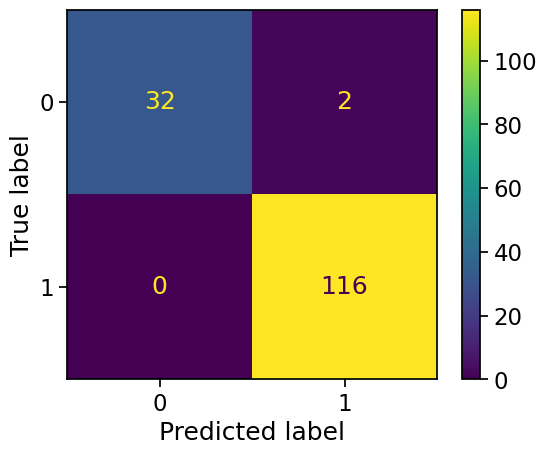

In [203]:
# Run the dual SVM model
ksvm = KernelSVM(C=1.0, kernel='gaussian')
ksvm.fit(X, y)

# Make predictions
y_pred_kernel = ksvm.predict(X)
accuracy_kernel = accuracy_score(y, y_pred_kernel)

print(f"Kernel SVM Accuracy: {accuracy_kernel}\n")
print(classification_report(y, y_pred_kernel))

cm = confusion_matrix(y, y_pred_kernel)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

## Least Squares Regression

In [204]:
data = io.loadmat('data\Regression_Data1.mat')
data

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Sun Mar 26 11:41:47 2023',
 '__version__': '1.0',
 '__globals__': [],
 'X': array([[ 6.29447373e+00,  8.26751712e+00, -4.43003562e+00,
          9.29777070e+00,  9.14333896e+00, -7.16227323e+00,
          5.84414659e+00, -9.28576643e+00,  3.57470310e+00,
         -2.15545961e+00,  4.12092176e+00, -9.07657219e+00,
          3.89657246e+00, -9.31107839e+00,  5.31033576e+00,
         -2.04712084e-01,  4.18729662e+00,  3.59405354e+00,
         -7.62004637e+00, -3.19228547e+00,  5.02534119e+00,
          3.98153445e+00,  9.44310599e-01, -4.84983492e+00,
          6.28569652e+00, -3.00032468e+00,  2.32089352e+00,
          6.61657256e+00,  8.34387328e+00,  5.07458189e+00,
         -8.48291421e+00,  5.58334460e+00,  1.37647322e+00,
         -3.25754711e+00, -3.77569916e+00,  2.03963883e+00,
          3.78429006e+00, -8.32357244e+00, -6.95243962e+00,
          9.92269433e+00, -7.86694460e+00,  5.49820929e+00,
         -8.3112

In [205]:
X = data['X'].T
y = data['Y'].ravel()

X = StandardScaler().fit_transform(X)

### Polynomial Regression Problem Formulation

#### 1. Feature Map Definition
Given a dataset with 100 samples $ \{(x_i, y_i)\}_{i=1}^{N} $, where:
- $ x_i \in \mathbb{R}^3 $
- $ y_i \in \mathbb{R} $
- $ y_i $ is a polynomial of degree at most 2 in $ x $

We define a feature map  $\phi(x)$  that includes all polynomial terms up to degree 2:

$$
\phi(x) = \begin{bmatrix} 1, x_1, x_2, x_3, x_1^2, x_2^2, x_3^2, x_1 x_2, x_1 x_3, x_2 x_3 \end{bmatrix}^\top
$$

**Feature Dimension:** $ \phi(x) \in \mathbb{R}^{10} $.

#### 2. Least Squares Problem Formulation
Assume the polynomial function:

$$
y_i = w^\top \phi(x_i) + \epsilon_i
$$

where:
- $ w \in \mathbb{R}^{10} $ (decision variable)
- $ \epsilon_i $ represents noise

To estimate $ w $, we minimize the least squares error:

$$
\min_w \sum_{i=1}^{N} \left( y_i - \phi(x_i)^\top w \right)^2
$$

**Matrix form:**

$$
\min_w \| y - \Phi w \|^2
$$

where:
- $ \Phi \in \mathbb{R}^{N \times 10} $ (design matrix with rows $ \phi(x_i)^\top $)
- $ y \in \mathbb{R}^{N} $ (output vector)

**Cost function:**

$$
J(w) = \frac{1}{N} \sum_{i=1}^{N} (y_i - \phi(x_i)^\top w)^2 = \frac{1}{N} \| y - \Phi w \|^2
$$


#### 3. Compute the Gradient of $ J(w) $
The gradient is given by:

$$
\mathbb{\nabla}_{J(w)} = -\frac{2}{N} \Phi^\top (y - \Phi w)
$$


#### 4. Optimization Algorithms
We solve using:
1. **Gradient Descent (GD):**
   $$
   w_{t+1} = w_t - \eta \nabla J(w_t)
   $$
2. **Accelerated Gradient Descent (AGD).**
3. **Stochastic Gradient Descent (SGD):**
   $$
   w_{t+1} = w_t - \eta \nabla J_i(w_t)
   $$

In [206]:
class PolynomialRegression:
    
    def __init__(self, degree=2):
        self.degree = degree
        self.coeffs = None
        self.GDLoss = None
        self.accelerated_GDLoss = None
        self.SGDLoss = None
        self.weight_error = None
        self.GDWeight = None
        self.SGDWeight = None
        self.accelerated_GDWeight = None

    def transform_features(self, X):
            
        n_samples, n_features = X.shape
        
        # Initialize the polynomial feature matrix with a bias term
        X_poly = np.ones((n_samples, 1))
        
        # For each degree, compute X^degree for each feature
        for d in range(1, self.degree + 1):
            for feat_idx in range(n_features):

                # Add new feature: X_i^d
                new_feature = X[:, feat_idx:feat_idx+1] ** d
                X_poly = np.hstack((X_poly, new_feature))
                
                # If using cross-terms (for multiple features and degree >= 2)
                if n_features > 1 and d >= 2:
                    for cross_feat_idx in range(feat_idx + 1, n_features):
                        for power_i in range(1, d):
                            power_j = d - power_i
                            
                            # Add cross-term: X_i^power_i * X_j^power_j
                            cross_term = (X[:, feat_idx] ** power_i * X[:, cross_feat_idx] ** power_j).reshape(-1, 1)
                            X_poly = np.hstack((X_poly, cross_term))
        
        return X_poly
    
    def fit_optimization_solver(self, X, y):
        
        X_poly = self.transform_features(X)

        n_samples, n_features = X_poly.shape
        w = cp.Variable(n_features)

        objective = cp.Minimize(cp.sum_squares(X_poly @ w - y))

        problem = cp.Problem(objective)
        problem.solve()

        self.coeffs = w.value
    
    def fit_normal_equation(self, X, y):
    
        X_poly = self.transform_features(X)
        
        # Normal equation: coeffs = (X^T X)^(-1) X^T y
        XTX = X_poly.T @ X_poly
        XTy = X_poly.T @ y
        
        # Implement matrix inversion using numpy
        self.coeffs = np.linalg.solve(XTX, XTy)
        
        return self
    
    def fit_gradient_descent(self, X, y, learning_rate=0.01, n_iterations=1000, tol=1e-6):
        
        self.GDLoss = []
        self.GDWeight = []

        X_poly = self.transform_features(X)
        n_samples, n_features = X_poly.shape
        
        # Initialize coefficients
        self.coeffs = np.zeros(n_features)
        self.GDWeight.append(self.coeffs.copy())

        # Gradient descent
        prev_cost = float('inf')

        for i in range(n_iterations):

            y_pred = X_poly @ self.coeffs
            error = y_pred - y
            cost = np.mean(error**2)

            self.GDLoss.append(cost)
            if abs(prev_cost - cost) < tol:
                break
                
            prev_cost = cost
            gradient = (2/n_samples) * X_poly.T @ error
            
            self.coeffs -= learning_rate * gradient
            self.GDWeight.append(self.coeffs.copy())
            
        return self
    
    def fit_batch_gradient_descent(self, X, y, learning_rate=0.01, n_epochs=10, batch_size=32, tol=1e-6):
        
        self.SGDLoss = []
        self.SGDWeight = []

        X_poly = self.transform_features(X)
        n_samples, n_features = X_poly.shape
        
        # Initialize coefficients
        self.coeffs = np.zeros(n_features)
        self.SGDWeight.append(self.coeffs.copy())
        
        prev_cost = float('inf')

        for epoch in range(n_epochs):
            
            # Shuffle data
            indices = np.random.permutation(n_samples)
            X_poly_shuffled = X_poly[indices]
            y_shuffled = y[indices]
            
            # Mini-batch gradient descent
            for i in range(0, n_samples, batch_size):

                end_idx = min(i + batch_size, n_samples)
                X_batch = X_poly_shuffled[i:end_idx]
                y_batch = y_shuffled[i:end_idx]
                
    
                y_pred = X_batch @ self.coeffs                
                error = y_pred - y_batch

                self.SGDLoss.append(np.mean(error**2))
                gradient = (2/len(X_batch)) * X_batch.T @ error
                
                # Update coefficients
                self.coeffs -= learning_rate * gradient
                self.SGDWeight.append(self.coeffs.copy())
            
            y_pred_all = X_poly @ self.coeffs
            cost = np.mean((y_pred_all - y)**2)
            
            # Check convergence
            if abs(prev_cost - cost) < tol:
                break
                
            prev_cost = cost
            
        return self
    
    def fit_accelerated_gradient_descent(self, X, y, learning_rate=0.01, n_iterations=1000, momentum=0.9, tol=1e-6):
        
        self.accelerated_GDLoss = []
        self.accelerated_GDWeight = []

        X_poly = self.transform_features(X)
        n_samples, n_features = X_poly.shape
        
        # Initialize coefficients
        self.coeffs = np.zeros(n_features)
        velocity = np.zeros(n_features)
        self.accelerated_GDWeight.append(self.coeffs.copy())
        
        prev_cost = float('inf')
        
        for i in range(n_iterations):
            
            # Look-ahead position with momentum
            look_ahead = self.coeffs + momentum * velocity
            y_pred = X_poly @ look_ahead
        
            error = y_pred - y
            gradient = (2/n_samples) * X_poly.T @ error
            
            # Update velocity using the gradient at look-ahead
            velocity = momentum * velocity - learning_rate * gradient
            
            # Update coefficients using the velocity
            self.coeffs += velocity
            self.accelerated_GDWeight.append(self.coeffs.copy())
            
            # Compute cost for convergence check
            y_pred_current = X_poly @ self.coeffs
            cost = np.mean((y_pred_current - y)**2)
            self.accelerated_GDLoss.append(cost)
    
            # Check convergence
            if abs(prev_cost - cost) < tol:
                break
                
            prev_cost = cost
            
        return self
    
    def predict(self, X):

        if self.coeffs is None:
            raise ValueError("Model not fitted. Call a fit method first.")
            
        X_poly = self.transform_features(X)
        return X_poly @ self.coeffs
    

Optimization solver coefficients: [-2.84947125e+00  3.67540718e+01  2.83339935e+01 -2.81418369e+01
 -6.30405217e+01  1.80025862e-14  2.30557622e+02 -8.55200199e-15
 -8.98748933e-15  9.99862785e-15]

Mean Squared Error: 3.977594949343452e-27


Text(0.5, 1.0, 'Error Distribution')

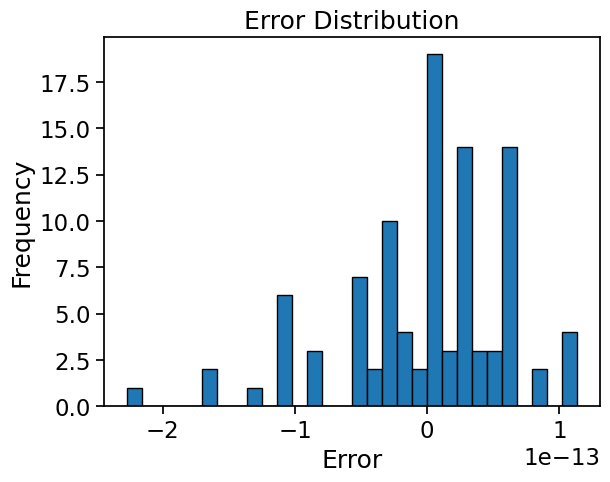

In [207]:
model = PolynomialRegression(degree=2)
model.fit_optimization_solver(X, y)
print(f"Optimization solver coefficients: {model.coeffs}\n")
w_ast = model.coeffs
w_ast = np.array(w_ast).reshape(-1, 1)  

y_pred = model.predict(X)
error = (y - y_pred)
mse = np.mean(error**2)
print(f"Mean Squared Error: {mse}")

# Histogram of errors
plt.figure()
plt.hist(error, bins=30, edgecolor='black')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.title('Error Distribution')

In [208]:
model = PolynomialRegression(degree=2)
model.fit_normal_equation(X, y)

print(f"Normal equation coefficients:\n {model.coeffs}\n")
print(f"Normal equation loss:\n {np.mean((model.predict(X) - y)**2)}")

Normal equation coefficients:
 [-2.84947125e+00  3.67540718e+01  2.83339935e+01 -2.81418369e+01
 -6.30405217e+01 -8.99730287e-15  2.30557622e+02  5.49350177e-14
 -8.52234557e-15  5.53940900e-14]

Normal equation loss:
 3.6505978553292414e-26


In [209]:
model = PolynomialRegression(degree=2)
model.fit_gradient_descent(X, y, learning_rate=0.2, n_iterations=1000, tol=1e-20)

print(f"Model Coefficients:\n {model.coeffs}\n")
loss = model.GDLoss
print(f"Model Loss: {loss[-1]}")

Model Coefficients:
 [-2.84947125e+00  3.67540718e+01  2.83339935e+01 -2.81418369e+01
 -6.30405217e+01  3.23136448e-11  2.30557622e+02  1.18777841e-10
  3.29048450e-11  1.65555642e-10]

Model Loss: 5.755662454347742e-20


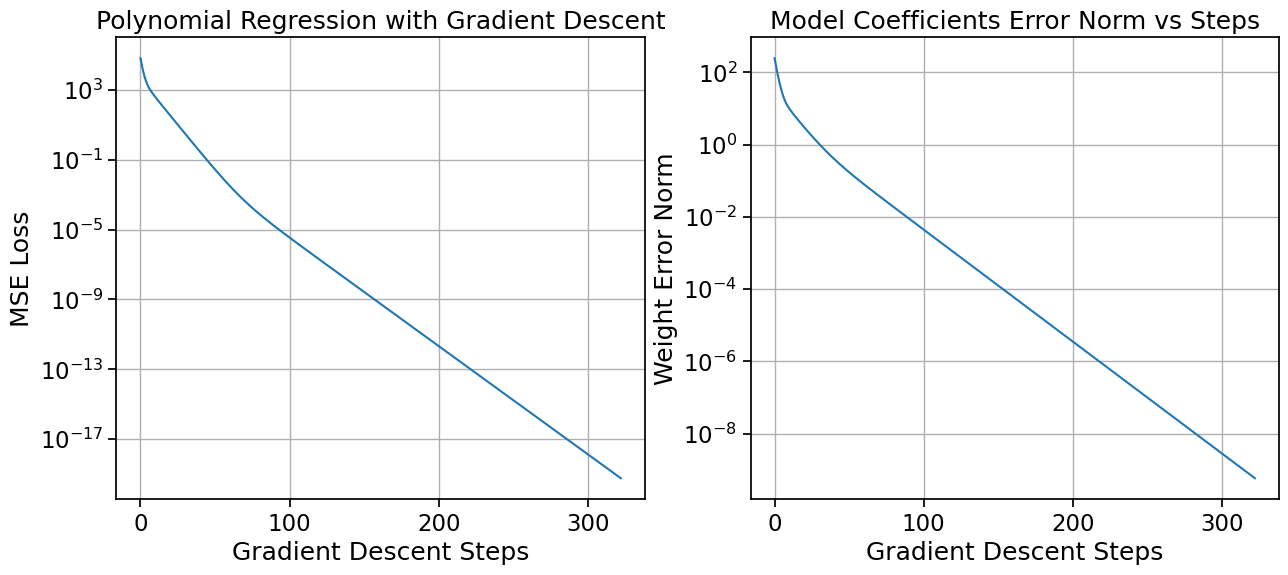

In [210]:
fig = plt.figure(figsize=(15, 6)) 

plt.subplot(1, 2, 1)
plt.plot(loss)
plt.xlabel('Gradient Descent Steps')
plt.ylabel('MSE Loss')
plt.yscale('log')
plt.title("Polynomial Regression with Gradient Descent")
plt.grid()

# Calculate the weight error for each step in gradient descent
weight_errors = []
for w in model.GDWeight:
    weight_error = np.linalg.norm(w_ast.flatten() - np.array(w))
    weight_errors.append(weight_error)
    
plt.subplot(1, 2, 2)
plt.plot(weight_errors)
plt.xlabel('Gradient Descent Steps')
plt.ylabel('Weight Error Norm')
plt.yscale('log')
plt.title("Model Coefficients Error Norm vs Steps")
plt.grid()

In [211]:
model = PolynomialRegression(degree=2)
model.fit_batch_gradient_descent(X, y, learning_rate=0.05, batch_size=4,
                        n_epochs=1000, tol=1e-30)

print(f"Model Coefficients:\n {model.coeffs}\n")
loss = model.SGDLoss
print(f"Model Loss: {loss[-1]}")

Model Coefficients:
 [-2.84947125e+00  3.67540718e+01  2.83339935e+01 -2.81418369e+01
 -6.30405217e+01  5.65045405e-15  2.30557622e+02  1.59289369e-15
 -4.34478287e-16 -1.48005599e-14]

Model Loss: 8.292505835683276e-27


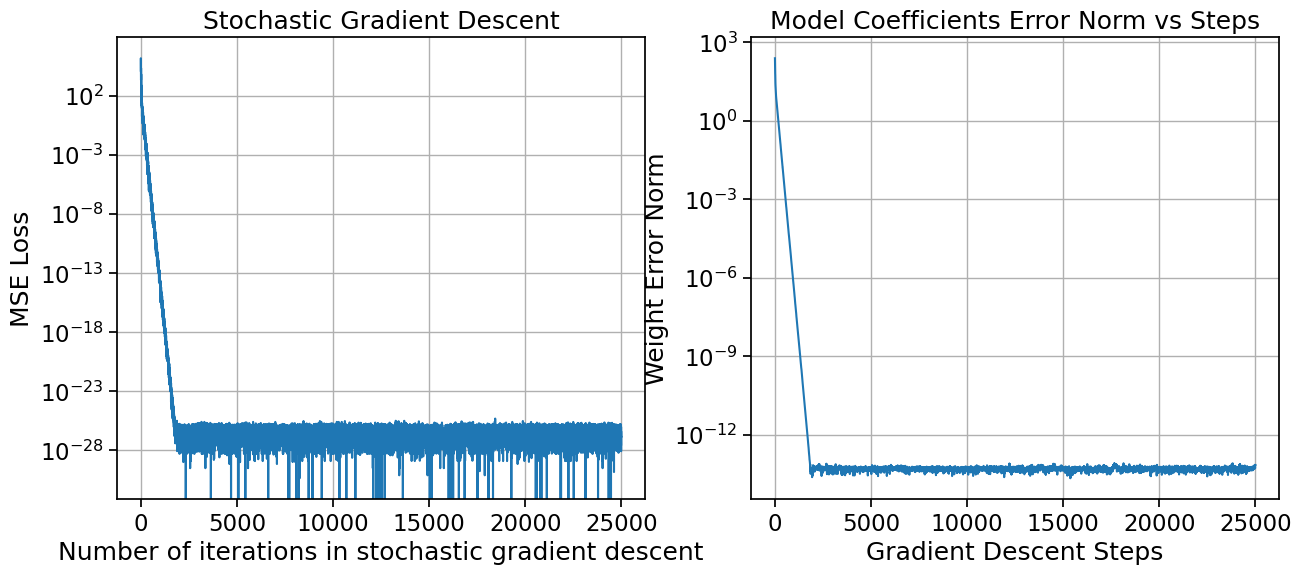

In [212]:
fig = plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.plot(loss)
plt.xlabel('Number of iterations in stochastic gradient descent')
plt.ylabel('MSE Loss')
plt.yscale('log')
plt.title("Stochastic Gradient Descent")
plt.grid()

# Calculate the weight error for each step in gradient descent
weight_errors = []
for w in model.SGDWeight:
    weight_error = np.linalg.norm(w_ast.flatten() - np.array(w))
    weight_errors.append(weight_error)

plt.subplot(1, 2, 2)
plt.plot(weight_errors)
plt.xlabel('Gradient Descent Steps')
plt.ylabel('Weight Error Norm')
plt.yscale('log')
plt.title("Model Coefficients Error Norm vs Steps")
plt.grid()

In [213]:
model = PolynomialRegression(degree=2)
model.fit_accelerated_gradient_descent(X, y, learning_rate=0.05, momentum=0.9,
                                 n_iterations=1000, tol=1e-30)

print(f"Model Coefficients:\n {model.coeffs}\n")
loss = model.accelerated_GDLoss
print(f"Model Loss: {loss[-1]}")

Model Coefficients:
 [-2.84947125e+00  3.67540718e+01  2.83339935e+01 -2.81418369e+01
 -6.30405217e+01  5.75939080e-15  2.30557622e+02  1.20396826e-14
  6.32543352e-15  2.35307807e-14]

Model Loss: 2.8393041618502664e-27


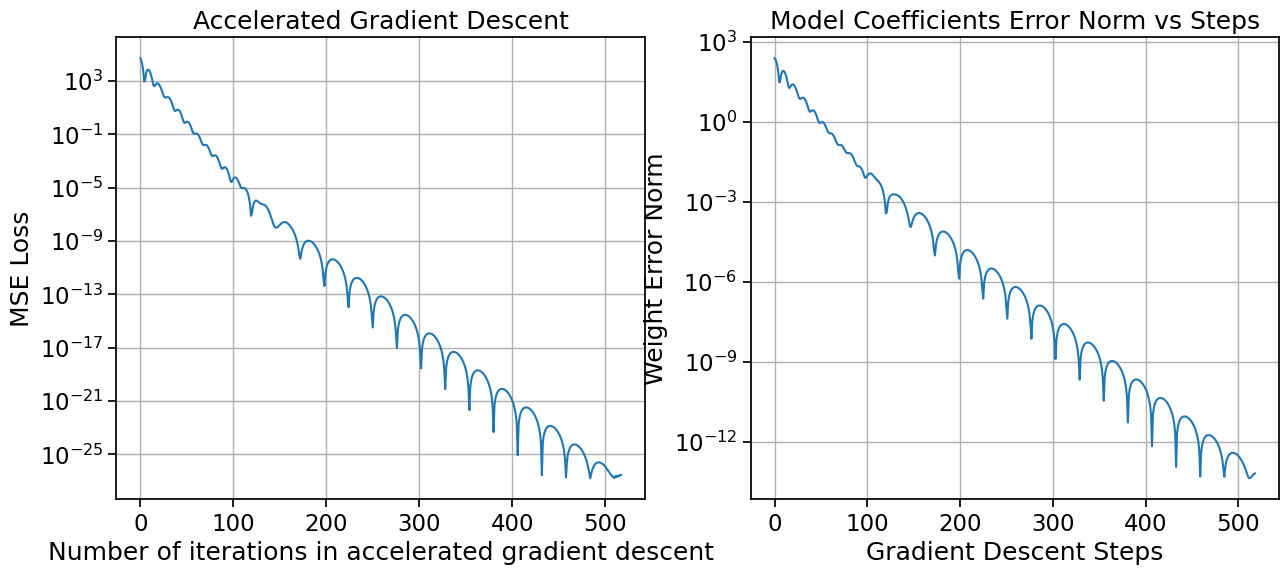

In [214]:
fig = plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.plot(loss)
plt.xlabel('Number of iterations in accelerated gradient descent')
plt.ylabel('MSE Loss')
plt.yscale('log')
plt.title("Accelerated Gradient Descent")
plt.grid()

# Calculate the weight error for each step in gradient descent
weight_errors = []
for w in model.accelerated_GDWeight:
    weight_error = np.linalg.norm(w_ast.flatten() - np.array(w))
    weight_errors.append(weight_error)

plt.subplot(1, 2, 2)
plt.plot(weight_errors)
plt.xlabel('Gradient Descent Steps')
plt.ylabel('Weight Error Norm')
plt.yscale('log')
plt.title("Model Coefficients Error Norm vs Steps")
plt.grid()


## Distributed Least Square Regression

### Network Topology
- There are **four agents** $ \{1,2,3,4\} $ communicating over a graph.
- The communication topology is defined by the given network graph (Figure 1).
- The weight $a_{ij}$ between two neighboring agents is **1/3**.

### Dataset Distribution
Each agent holds a subset of the dataset:
- **Agent 1**: First 20 data points
- **Agent 2**: Next 25 data points
- **Agent 3**: Next 30 data points
- **Agent 4**: Final 25 data points

### Objective Function
The agents collectively minimize the least squares loss:

$$
\min_w f(w) = \sum_{i=1}^{4} f_i(w)
$$

where the local loss function for agent $i$ is:

$$
f_i(w) = \frac{1}{|D_i|} \sum_{(x_j, y_j) \in D_i} \| y_j - x_j^T w \|^2
$$

Here, $w$ is the global regression parameter to be learned.

### Distributed Gradient Descent Algorithm
Each agent updates its local model using a combination of **local gradient descent** and a **consensus averaging step**.

#### Algorithm Steps
1. **Initialize Local Models**: Each agent initializes its local model $w_{i,0}$ randomly.
2. **Set Step Size**: The learning rate is defined as:
    $$
    \eta_t = \frac{1}{2\beta\sqrt{t}}
    $$
    where $\beta$ is the smoothness parameter.
3. **Local Gradient Descent Update**:
    Each agent updates its local model using gradient descent:
    $$
    w_{i,t+1} = w_{i,t} - \eta_t \nabla f_i(w_{i,t})
    $$
4. **Consensus Step**:
    Each agent exchanges information with its neighbors and updates its model as:
    $$
    w_{i,t+1} := w_{i,t+1} + \sum_{j \in \mathcal{N}(i)} a_{ij} (w_{j,t}-w_{i,t})
    $$

#### Performance Metrics
To evaluate the convergence of the distributed gradient descent, we track the following metrics:

1. **Deviation from Consensus**:
    $$
    \| w_{i,t} - \bar{w}_t \|^2
    $$
    where $\bar{w}_t$ is the average model:
    $$
    \bar{w}_t = \frac{1}{4} \sum_{i=1}^{4} w_{i,t}
    $$
    - This should converge to **0**, indicating all agents agree on a common model.
    - **Plot in log scale**.

2. **Error with respect to optimal solution**:
    $$
    \| w^* - \bar{w}_t \|^2
    $$
    - This measures the deviation of the distributed solution from the true least squares solution $w^*$.
    - Should also converge to **0** over time.

In [215]:
# Load data
data = io.loadmat('data/Regression_Data1.mat')
X = data['X'].T
y = data['Y'].T.flatten()

X = StandardScaler().fit_transform(X)

In [216]:
agents_data = {
    1: (X[:20], y[:20]),
    2: (X[20:45], y[20:45]),
    3: (X[45:75], y[45:75]),
    4: (X[75:], y[75:])
}

In [217]:
w_agents = {i: np.random.randn(X.shape[1]) for i in range(1, 5)}

A = np.array([
    [1/3, 1/3, 0, 1/3],
    [1/3, 1/3, 1/3, 0],
    [0, 1/3, 1/3, 1/3],
    [1/3, 0, 1/3, 1/3]
])

In [218]:
def gradient(X, y, w):
    return -X.T @ (y - X @ w) / len(y)

In [219]:
dim_w = X.shape[1]

w = cp.Variable(dim_w)
objective = cp.Minimize((1 / 2) * cp.norm(X @ w - y, 2) ** 2)

problem = cp.Problem(objective)
problem.solve()

w_opt = w.value
print("Optimal w*:\n", w_opt)

Optimal w*:
 [ 50.30386578  18.70442785 -39.91201102]


In [ ]:
def distributed_least_squares(agents_data, A, num_iterations, beta, w_opt, dim_w):
    
    # Initialize agent weights randomly
    w_agents = {i: np.random.randn(dim_w) for i in range(1, 5)}

    w_diff_norms = []
    errors = {i: [] for i in range(1, 5)}

    for t in range(1, num_iterations + 1):
        eta_t = 1 / (2 * beta * np.sqrt(t))  

        w_new = {}
        for i in range(1, 5):
            X_i, y_i = agents_data[i]
            local_grad = gradient(X_i, y_i, w_agents[i])

            # Consensus term based on adjacency matrix
            consensus_term = sum(A[i-1, j-1] * (w_agents[j] - w_agents[i])
                                 for j in range(1, 5) if A[i-1, j-1] > 0)

            # Update rule
            w_new[i] = w_agents[i] - eta_t * local_grad + consensus_term

        # Compute average weight across agents
        w_avg_t = np.mean(list(w_agents.values()), axis=0)

        for i in range(1, 5):
            w_agents[i] = w_new[i]
            errors[i].append(np.linalg.norm(w_agents[i] - w_avg_t) ** 2)

        # Compute deviation from optimal weight
        w_diff_norms.append(np.linalg.norm(w_opt - w_avg_t) ** 2)

    return {"errors": errors, "w_diff_norms": w_diff_norms}

In [224]:
beta = np.linalg.norm(X.T @ X, ord=2)
num_iterations = 100000

result = distributed_least_squares(agents_data, A, 
                                   num_iterations=num_iterations, 
                                   beta=beta, w_opt=w_opt, dim_w=X.shape[1])
errors = result["errors"]
w_diff_norms = result["w_diff_norms"]

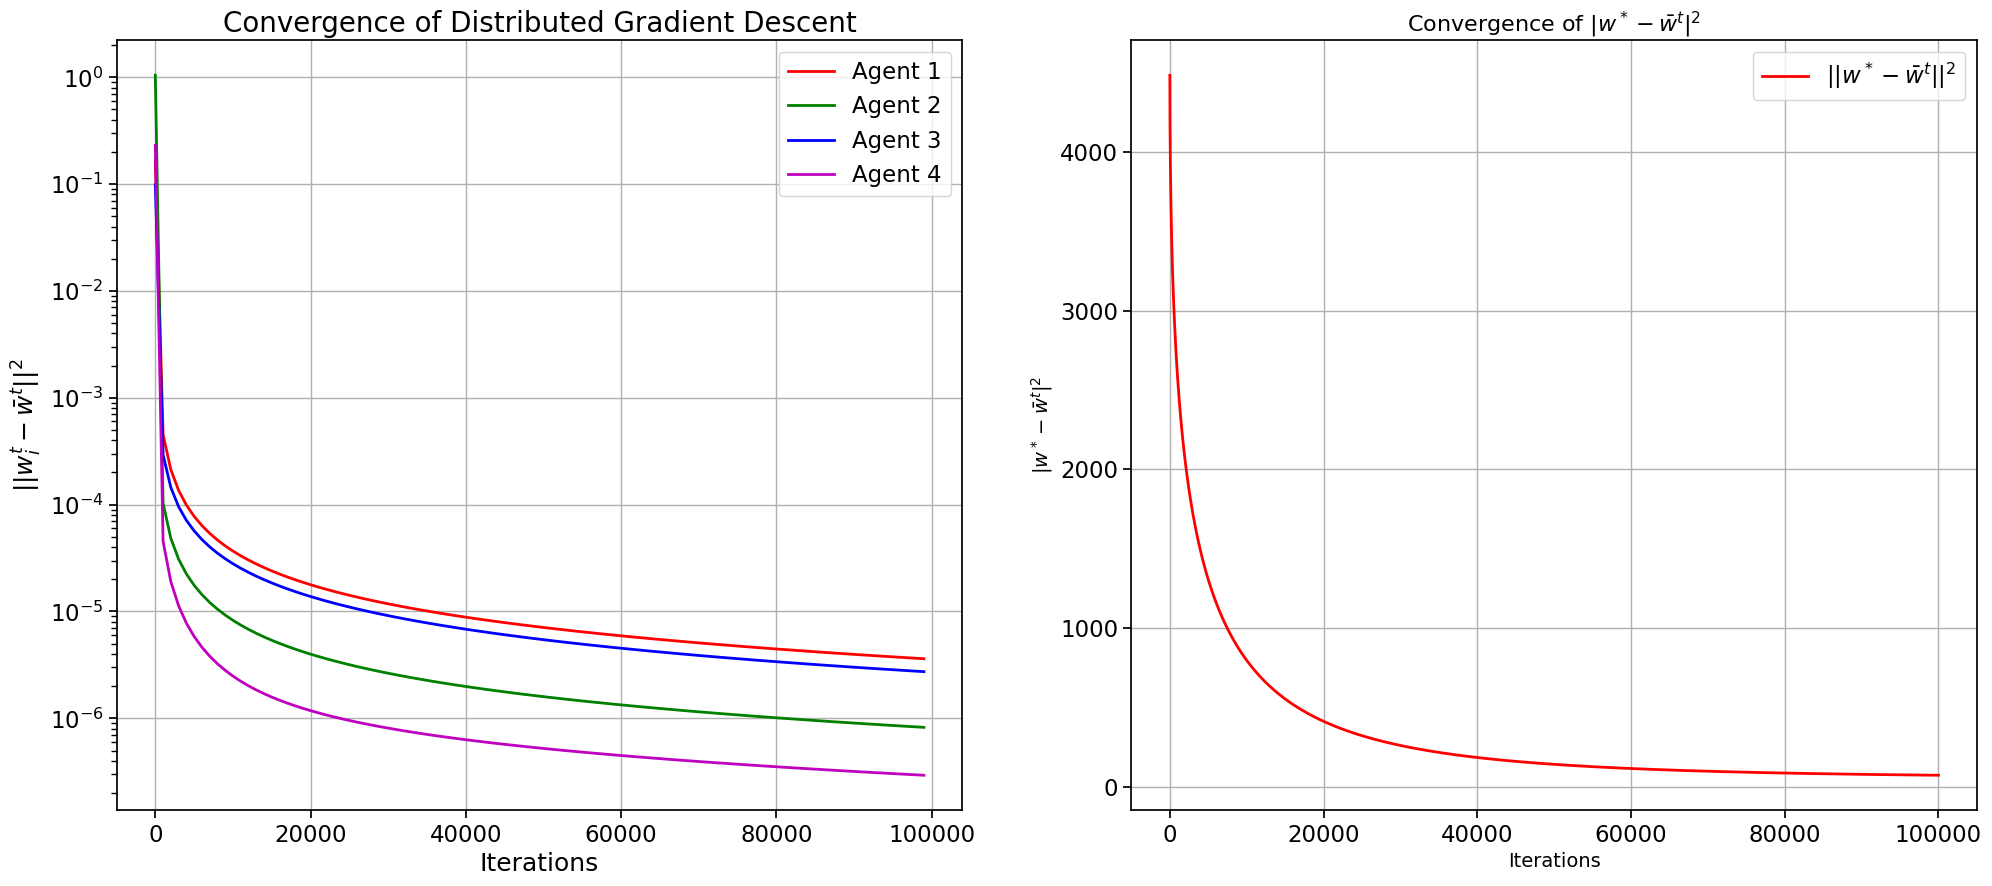

In [225]:
plt.figure(figsize=(24, 10))


plt.subplot(1, 2, 1)
colors = ['r', 'g', 'b', 'm']
for i in range(1, 5):
    plt.plot(range(1, num_iterations + 1, 1000), errors[i][::1000],
             label=f'Agent {i}', color=colors[i-1], linewidth=2)

plt.yscale('log')
plt.xlabel('Iterations', fontsize=18)
plt.ylabel(r'$||w_i^t - \bar{w}^t||^2$', fontsize=18)
plt.title('Convergence of Distributed Gradient Descent', fontsize=20)
plt.legend()
plt.grid()


plt.subplot(1, 2, 2)
plt.plot(range(1, num_iterations + 1), w_diff_norms,
         label=r'$||w^* - \bar{w}^t||^2$', color='red', linewidth=2)

plt.xlabel('Iterations', fontsize=14)
plt.ylabel(r'$\|w^* - \bar{w}^t\|^2$', fontsize=14)
plt.title(r'Convergence of $\|w^* - \bar{w}^t\|^2$', fontsize=16)
plt.legend()
plt.grid()
plt.show()